# Import required liberaries

In [1]:
#import liberaries
import numpy as np
import pandas as pd
from pandas import read_csv
from numpy import nan
from numpy import isnan
from pandas import to_numeric
import matplotlib.pyplot as plt

# load dataset

In [2]:
# load data
dataset = read_csv('heart-rate-time-series.csv')
dataset.columns=['HR'] #make heading for the column
dataset.head()

,HR
0,91.4634
1,91.1834
2,91.8788
3,91.1772
4,89.7992


In [3]:
from numpy import nan
from numpy import isnan
from pandas import to_numeric
# mark all missing values
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')
dataset.head()

,HR
0,91.463402
1,91.183403
2,91.878799
3,91.177200
4,89.799202


# Plot dataset to get more information about dataset

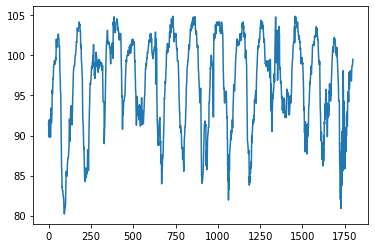

In [4]:
plt.plot(dataset)

# Moving averaging over the dataset to make it smoother

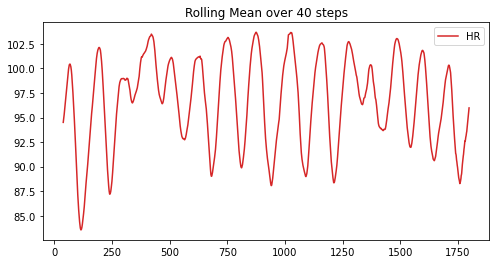

In [5]:
dataset.rolling(window = 40).mean().plot(figsize=(8,4), color="tab:red", title="Rolling Mean over 40 steps");

# Do some statistics to got more insights

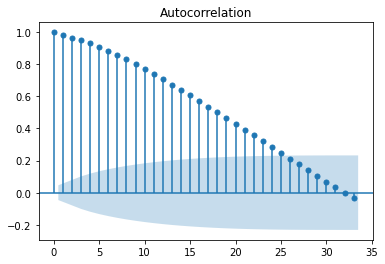

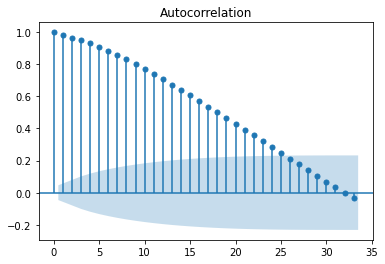

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(dataset) #Auto Correlation Function ACF Plot or Autocorrelation plot

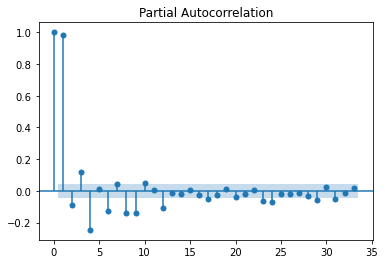

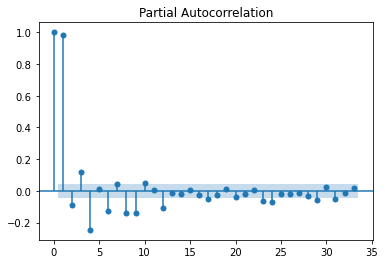

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(dataset) #partial autocorrelation function (PACF) plot

# Dicky Fuller test to see whether the time series is stationary or not

In [8]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(dataset['HR'], autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -7.457988233959135
2. P-Value :  5.447866825089469e-11
3. Num Of Lags :  23
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1775
5. Critical Values :
	 1% :  -3.4340394547116797
	 5% :  -2.863169689048283
	 10% :  -2.5676375957944853


# Differencing to make the time series stationary

In [9]:
# from pandas import Series
# # create a differenced series
# def difference(dataset, interval=10):
#     diff = list()
#     for i in range(interval, len(dataset)):
#         value = dataset[i] - dataset[i - interval]
#         diff.append(value)
#     return Series(diff)

# dataset=difference(dataset, interval=10)


# Normalizing the dataset

In [10]:
# Normalize time series data
from sklearn.preprocessing import MinMaxScaler
# prepare data for normalization
values=dataset.to_numpy()
values = values.reshape((len(values), 1))
# train the normalization
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset
dataset = scaler.transform(values)
dataset

Min: 80.213898, Max: 104.894997


array([[-0.08841181],
       [-0.11110115],
       [-0.05475044],
       ...,
       [ 0.52234745],
       [ 0.5488291 ],
       [ 0.5644846 ]], dtype=float32)

In [11]:
dataset.shape

(1799, 1)

# Transform time series data to supervised data

In [12]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=360, n_out=600, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [13]:
data = series_to_supervised(dataset, 360, 600) #transform time series dataset to supervised datasets
print(data)

      var1(t-360)  var1(t-359)  var1(t-358)  var1(t-357)  var1(t-356)  \
360     -0.088412    -0.111101    -0.054750    -0.111604    -0.223268   
361     -0.111101    -0.054750    -0.111604    -0.223268    -0.178059   
362     -0.054750    -0.111604    -0.223268    -0.178059    -0.043090   
363     -0.111604    -0.223268    -0.178059    -0.043090    -0.052182   
364     -0.223268    -0.178059    -0.043090    -0.052182    -0.114537   
...           ...          ...          ...          ...          ...   
1195     0.740126     0.790689     0.837852     0.872210     0.873831   
1196     0.790689     0.837852     0.872210     0.873831     0.849196   
1197     0.837852     0.872210     0.873831     0.849196     0.858191   
1198     0.872210     0.873831     0.849196     0.858191     0.882744   
1199     0.873831     0.849196     0.858191     0.882744     0.906731   

      var1(t-355)  var1(t-354)  var1(t-353)  var1(t-352)  var1(t-351)  ...  \
360     -0.178059    -0.043090    -0.052182  

# split dataset into train and test sets

In [14]:
# split into train and test sets
values = data.values
n_train = int(len(values)*0.8) # 80% of data for training
train = values[:n_train, :]
test = values[n_train:, :]
n_train, train.shape, test.shape

(672, (672, 960), (168, 960))

In [15]:
np.info(train)

class:  ndarray
shape:  (672, 960)
strides:  (4, 3360)
itemsize:  4
aligned:  True
contiguous:  False
fortran:  False
data pointer: 0xd895a89040
byteorder:  little
byteswap:  False
type: float32


In [16]:
np.info(test)

class:  ndarray
shape:  (168, 960)
strides:  (4, 3360)
itemsize:  4
aligned:  True
contiguous:  False
fortran:  False
data pointer: 0xd895a89ac0
byteorder:  little
byteswap:  False
type: float32


In [17]:
np.info(train[:, -600:])

class:  ndarray
shape:  (672, 600)
strides:  (4, 3360)
itemsize:  4
aligned:  True
contiguous:  False
fortran:  False
data pointer: 0xd895bb0540
byteorder:  little
byteswap:  False
type: float32


# split train and test sets into input and outputs

In [18]:
# split into input and outputs
train_X, train_y = train[:, :-600], train[:, -600:] #600 is the number of outpout
test_X, test_y = test[:, :-600], test[:, -600:]
train_X.shape, train_y.shape

((672, 360), (672, 600))

# prepare data to enter the network

In [19]:
# reshape input to be 3D [samples, timesteps, features]
features =1
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1],features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1],features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(672, 360, 1) (672, 600) (168, 360, 1) (168, 600)


# build the model

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from keras import layers, callbacks
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

dropout=0.5
units=10
nout=600

# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    # First layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units, activation='relu', return_sequences=True),input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    # Second layer of BiLSTM
    #model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(nout))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    # First layer of LSTM
    model.add(m (units = units, activation='relu', input_shape = [train_X.shape[1], train_X.shape[2]]))
    model.add(Dropout(dropout)) 
    # Second layer of LSTM
    #model.add(m (units = units))                 
    #model.add(Dropout(dropout))
    model.add(Dense(nout)) 
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


# BiLSTM
model_bilstm = create_model_bilstm(units)

# GRU and LSTM 
model_gru = create_model(units, GRU)
model_lstm = create_model(units, LSTM)

# define a function to fit the model

In [28]:
#fit models
epoch, batch= 10,1
def fit_model(model):
    history = model.fit(train_X, train_y, epochs=epoch, batch_size=batch, validation_data=(test_X, test_y), verbose=1, shuffle=False)
    return history

#history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
#history_gru = fit_model(model_gru)

Epoch 1/10
672/672 [==============================] - 41s 60ms/step - loss: 91032895488.0000 - val_loss: 0.2115
Epoch 2/10
672/672 [==============================] - 40s 60ms/step - loss: 0.2500 - val_loss: 0.2057
Epoch 3/10
672/672 [==============================] - 46s 68ms/step - loss: 0.2412 - val_loss: 0.2029
Epoch 4/10
672/672 [==============================] - 49s 73ms/step - loss: 0.2398 - val_loss: 0.2033
Epoch 5/10
672/672 [==============================] - 50s 75ms/step - loss: 0.2356 - val_loss: 0.2037
Epoch 6/10
672/672 [==============================] - 52s 78ms/step - loss: 0.2353 - val_loss: 0.2054
Epoch 7/10
672/672 [==============================] - 52s 77ms/step - loss: 0.2343 - val_loss: 0.2066
Epoch 8/10
672/672 [==============================] - 53s 79ms/step - loss: 0.2294 - val_loss: 0.2091
Epoch 9/10
672/672 [==============================] - 54s 80ms/step - loss: 0.2324 - val_loss: 0.2093
Epoch 10/10
672/672 [==============================] - 53s 79ms/step - l

# plot the results

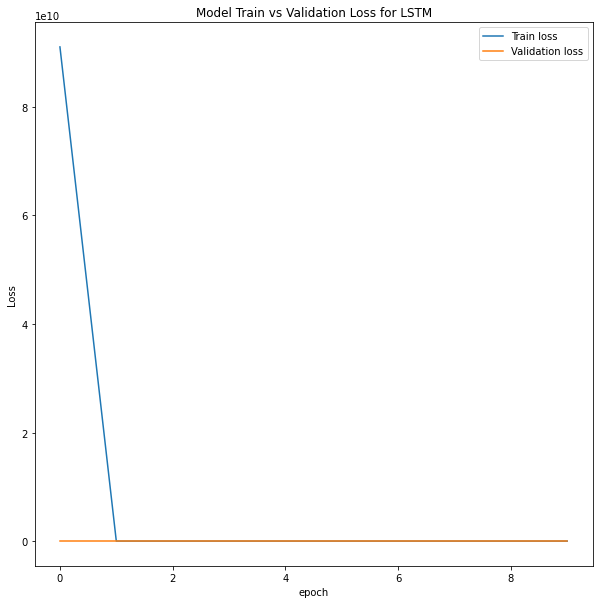

In [45]:
#plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

#plot_loss (history_bilstm, 'BiLSTM')
plot_loss (history_lstm, 'LSTM')
#plot_loss (history_gru, 'GRU')

In [30]:
#model_bilstm.summary()
model_lstm.summary()
#model_gru.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 10)                480       
                                                                 
 dropout_8 (Dropout)         (None, 10)                0         
                                                                 
 dense_8 (Dense)             (None, 600)               6600      
                                                                 
Total params: 7,080
Trainable params: 7,080
Non-trainable params: 0
_________________________________________________________________


# make prediction

In [31]:
#make prediction
def prediction(model):
    prediction = model.predict(test_X)
    return prediction

#prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
prediction_lstm.shape, prediction_gru.shape ,test_X.shape

((168, 600), (168, 600), (168, 360))

# rescale the predictions into actual scale and calculate RMSE

In [32]:
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

# invert scaling lstm
inv_yhat_lstm = concatenate((prediction_lstm, test_X[:, 1:]), axis=1)
inv_yhat_lstm = scaler.inverse_transform(inv_yhat_lstm)
inv_yhat_lstm = inv_yhat_lstm[:,0]

# invert scaling gru
#inv_yhat_gru = concatenate((prediction_gru, test_X[:, 1:]), axis=1)
#inv_yhat_gru = scaler.inverse_transform(inv_yhat_gru)
#inv_yhat_gru = inv_yhat_gru[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), nout))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse_lstm = sqrt(mean_squared_error(inv_y, inv_yhat_lstm))
#rmse_gru = sqrt(mean_squared_error(inv_y, inv_yhat_gru))
print('Test RMSE lstm: %.3f' % rmse_lstm)
#print('Test RMSE gru: %.3f' % rmse_gru)
inv_yhat_lstm.shape

Test RMSE lstm: 2.939


(168,)

# Define a function to calculate MAE and RMSE

In [33]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    #print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')


#evaluate_prediction(prediction_bilstm, test_y, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, test_y, 'LSTM')
#evaluate_prediction(prediction_gru, test_y, 'GRU')

LSTM:
Root Mean Square Error: 0.4580



In [34]:
inv_yhat_lstm.shape, inv_y.shape

((168,), (168,))

# put actual values and predicted values alltogether in a dataframe and plot them 

In [46]:
df = pd.DataFrame({'observation': inv_y, 'prediction': inv_yhat_lstm} , columns=['observation', 'prediction']) #'gru prediction2': inv_yhat_gru, 'bilstm prediction': inv_yhat_bilstm
df.head(20)

,observation,prediction
0,98.344498,98.624763
1,97.737602,98.139389
2,96.772797,97.718750
3,95.825600,97.314781
4,95.791298,96.922714
5,95.923599,96.610977
6,95.394203,96.367989
7,94.375702,96.128822
8,94.054199,95.862381
9,94.796303,95.629387


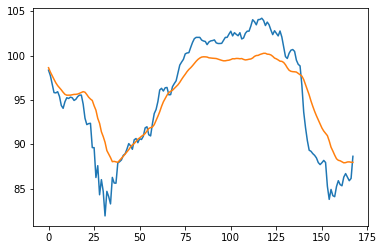

In [47]:
plt.plot(df)

# Result Interpretion:
We can see from the above plot and dataframe that the predictions are very close to the actual values which is reasonable and shows that the network works correctly
but it still could be more optimized 